# Win Probability Charts 2019

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

import requests
import team_colors as colors

from scipy.interpolate import make_interp_spline, BSpline

import csaps


sns.set(style="whitegrid", 
        palette="pastel", 
        font='Circular Spotify Text', 
        font_scale = 1.1, 
        rc= {'grid.color': '.95', 'xtick.color': '.3', 'ytick.color': '.3'})


## Data

In [3]:
df = pd.read_csv("../data/nflscrapR/reg_pbp_2019.csv")

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (168,169,192,193,233,234,235,240,242,243) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
#Adding week data to main dataframe

try:
    response_reg = requests.get('http://www.nfl.com/feeds-rs/schedules/2019.json').json()
except requests.exceptions.RequestException as e:
    print(e)

schedules = pd.DataFrame.from_dict(response_reg['gameSchedules'])
schedules = schedules.loc[schedules['seasonType'] == 'REG', ['gameId', 'week']]

schedules = schedules.rename(columns={'gameId' : 'game_id'})

df = df.merge(schedules, how='left', on=['game_id'])

In [5]:
df.head()

,Unnamed: 0,play_id,game_id,home_team,away_team,posteam,posteam_type,defteam,side_of_field,yardline_100,...,penalty_player_name,penalty_yards,replay_or_challenge,replay_or_challenge_result,penalty_type,defensive_two_point_attempt,defensive_two_point_conv,defensive_extra_point_attempt,defensive_extra_point_conv,week
0,1,35,2019090500,CHI,GB,GB,away,CHI,CHI,35.0,...,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0,1
1,2,50,2019090500,CHI,GB,GB,away,CHI,GB,75.0,...,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0,1
2,3,71,2019090500,CHI,GB,GB,away,CHI,GB,75.0,...,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0,1
3,4,95,2019090500,CHI,GB,GB,away,CHI,GB,75.0,...,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0,1
4,5,125,2019090500,CHI,GB,GB,away,CHI,GB,85.0,...,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0,1


In [6]:
list(df.columns)

['Unnamed: 0',
 'play_id',
 'game_id',
 'home_team',
 'away_team',
 'posteam',
 'posteam_type',
 'defteam',
 'side_of_field',
 'yardline_100',
 'game_date',
 'quarter_seconds_remaining',
 'half_seconds_remaining',
 'game_seconds_remaining',
 'game_half',
 'quarter_end',
 'drive',
 'sp',
 'qtr',
 'down',
 'goal_to_go',
 'time',
 'yrdln',
 'ydstogo',
 'ydsnet',
 'desc',
 'play_type',
 'yards_gained',
 'shotgun',
 'no_huddle',
 'qb_dropback',
 'qb_kneel',
 'qb_spike',
 'qb_scramble',
 'pass_length',
 'pass_location',
 'air_yards',
 'yards_after_catch',
 'run_location',
 'run_gap',
 'field_goal_result',
 'kick_distance',
 'extra_point_result',
 'two_point_conv_result',
 'home_timeouts_remaining',
 'away_timeouts_remaining',
 'timeout',
 'timeout_team',
 'td_team',
 'posteam_timeouts_remaining',
 'defteam_timeouts_remaining',
 'total_home_score',
 'total_away_score',
 'posteam_score',
 'defteam_score',
 'score_differential',
 'posteam_score_post',
 'defteam_score_post',
 'score_differential

In [7]:
# Function to getting all the game ID's for a team

def get_schedule(team=None):
    
    if team:
    
        schedule = (
            df[(df['home_team'] == team) | (df['away_team'] == team)]
                .groupby(['game_date', 'game_id', 'away_team', 'home_team', 'week'])
                [['total_away_score','total_home_score']]
                .max()
                .reset_index()
                .sort_values('game_date')
                )
    else:
        schedule = (df
                    .groupby(['game_date', 'game_id', 'away_team', 'home_team', 'week'])[['total_away_score','total_home_score']]
                    .max()
                    .reset_index()
                    .sort_values('game_date'))

    return schedule

### Mirror charts 50/50

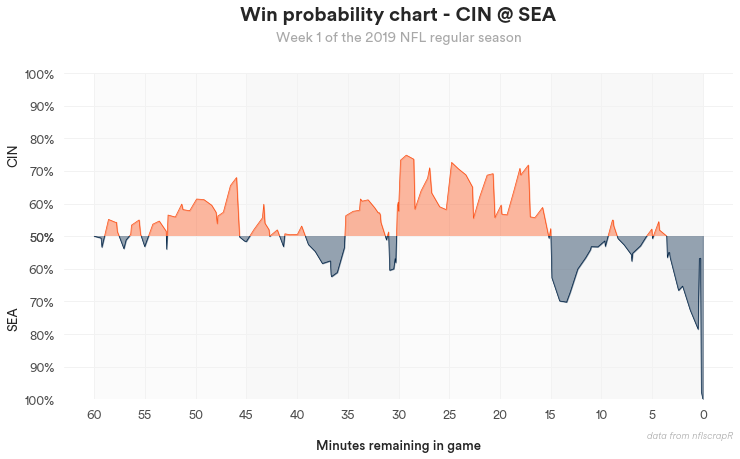

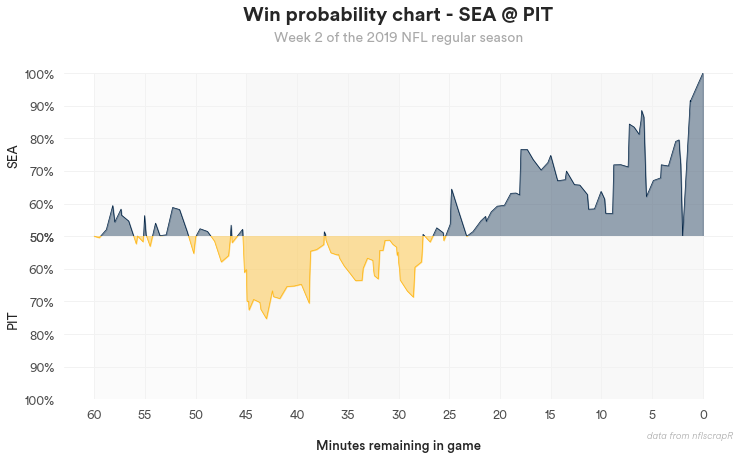

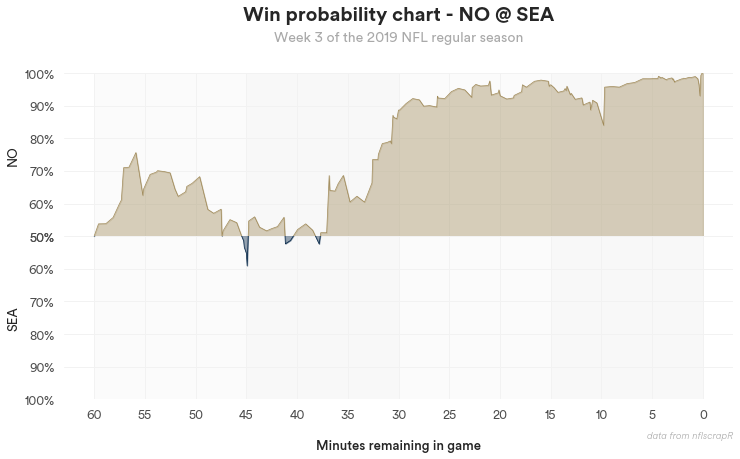

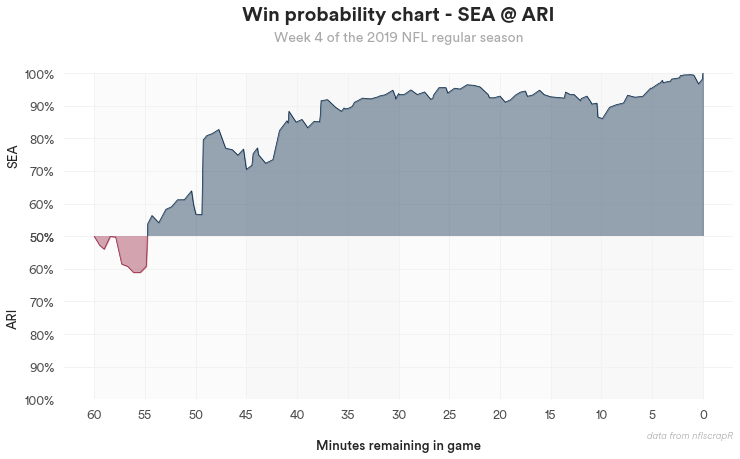

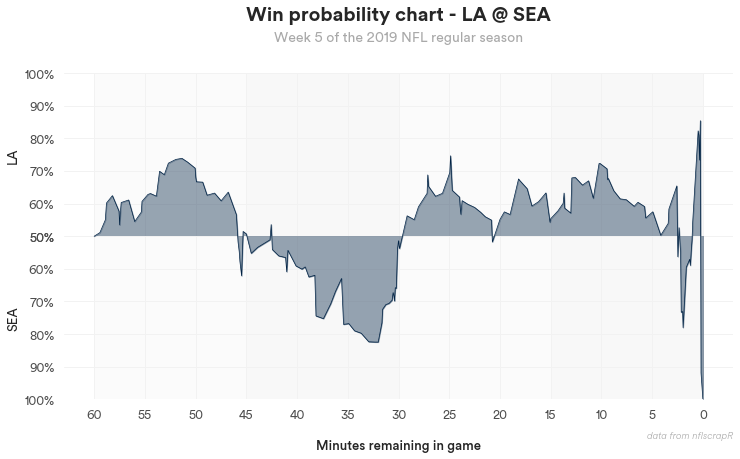

In [8]:
# Looping through SFs game IDs, pulling home team and away team to use as column names and pull correct team colors

team = 'SEA'
schedule = get_schedule(team)
team_colors = colors.get_colors()

game_ids = list(schedule['game_id'])
bg_alpha_1 = 0.3
bg_alpha_2 = 0.65


for g, game in enumerate(game_ids):
    
    home_team, away_team, week = schedule[schedule['game_id'] == game][['home_team', 'away_team', 'week']].values[0]
    
    win_probs = (df[df['game_id'] == game][['away_wp', 'home_wp', 'game_seconds_remaining']]
                 .rename(columns={'home_wp': home_team, 'away_wp': away_team, 'game_seconds_remaining': 'game_minutes_remaining'})
                 )
    
    win_probs = win_probs.groupby('game_minutes_remaining')[home_team, away_team].mean().reset_index().dropna()
    
    win_probs['game_minutes_remaining'] = win_probs['game_minutes_remaining']/60
      
    f, ax = plt.subplots(figsize=(12, 6))
    plt.subplots_adjust(hspace = 0)
    
    #Draw home team
    
    plt.subplot(2, 1, 1)
    
    #plt.title('Win probabilities - {} @ {}\n'.format(away_team, home_team), fontsize=20, weight='bold')
   
    ax = sns.lineplot(x=win_probs['game_minutes_remaining'], y=win_probs[away_team], color=team_colors[away_team], lw=0.7)
    
    ax.text(x=0.5, y=1.3, s='Win probability chart - {} @ {}'.format(away_team, home_team), fontsize=20, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
    ax.text(x=0.5, y=1.18, s='Week {} of the 2019 NFL regular season'.format(week), fontsize=14, color='darkgray', ha='center', va='bottom', transform=ax.transAxes)

    
    plt.axhline(y=50, color='grey', linestyle='--', alpha=0.3)
    
    plt.fill_between(win_probs['game_minutes_remaining'].values, 
                     win_probs[away_team].values, 
                     color=team_colors[away_team], 
                     alpha = 0.4,
                     edgecolor=None
                    )
    
    #backgrounds to separate quarters
    plt.fill_between([60,45], y1=100, color='whitesmoke', alpha=bg_alpha_1, edgecolor=None, zorder=-2)
    plt.fill_between([45,30], y1=100, color='whitesmoke', alpha=bg_alpha_2, edgecolor=None, zorder=-2)
    plt.fill_between([30,15], y1=100, color='whitesmoke', alpha=bg_alpha_1, edgecolor=None, zorder=-2)
    plt.fill_between([15,0], y1=100, color='whitesmoke', alpha=bg_alpha_2, edgecolor=None, zorder=-2)  
    
    ax.set_ylim((0.5,1))
    ax.yaxis.set_major_formatter(FuncFormatter('{:.0%}'.format))
    ax.xaxis.set_major_locator(plt.MaxNLocator(14))
    
    ax.invert_xaxis()
    
    plt.subplot(2, 1, 2)

    
    ax = sns.lineplot(x=win_probs['game_minutes_remaining'], y=win_probs[home_team], color=team_colors[home_team], lw=0.7)
    
    plt.fill_between(win_probs['game_minutes_remaining'].values, 
                     win_probs[home_team].values, 
                     color=team_colors[home_team], 
                     alpha = 0.4,
                     edgecolor=None
                    )
    
    #backgrounds to separate quarters
    plt.fill_between([60,45], y1=100, color='whitesmoke', alpha=bg_alpha_1, edgecolor=None, zorder=-2)
    plt.fill_between([45,30], y1=100, color='whitesmoke', alpha=bg_alpha_2, edgecolor=None, zorder=-2)
    plt.fill_between([30,15], y1=100, color='whitesmoke', alpha=bg_alpha_1, edgecolor=None, zorder=-2)
    plt.fill_between([15,0], y1=100, color='whitesmoke', alpha=bg_alpha_2, edgecolor=None, zorder=-2)  

    
    ax.set_ylim((0.5,1))
    ax.yaxis.set_major_formatter(FuncFormatter('{:.0%}'.format))
    ax.xaxis.set_major_locator(plt.MaxNLocator(14))

    
    ax.invert_xaxis()
    ax.invert_yaxis()
    
    
    
    plt.xlabel("\nMinutes remaining in game", weight='medium')
    
    ax.text(x=1, 
        y=-0.25, 
        s='data from nflscrapR', 
        fontsize=10,
        weight='light',
        style='italic',
        color='darkgray', 
        ha='right', 
        va='bottom', 
        transform=ax.transAxes)    
    
    sns.despine(left=True, right=True, bottom=True, top=True)
    
    filename = str(away_team + '_at_' + home_team)
    
    plt.savefig('output/' + filename + '.png', format='png', dpi=300, bbox_inches='tight')
    
    

### ...with smoothing

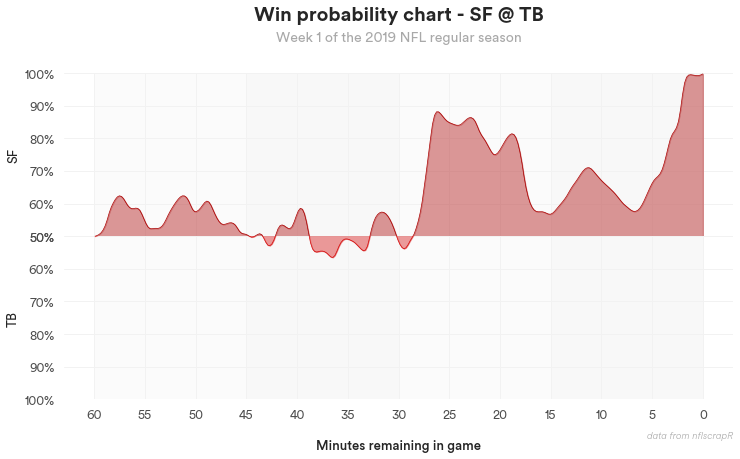

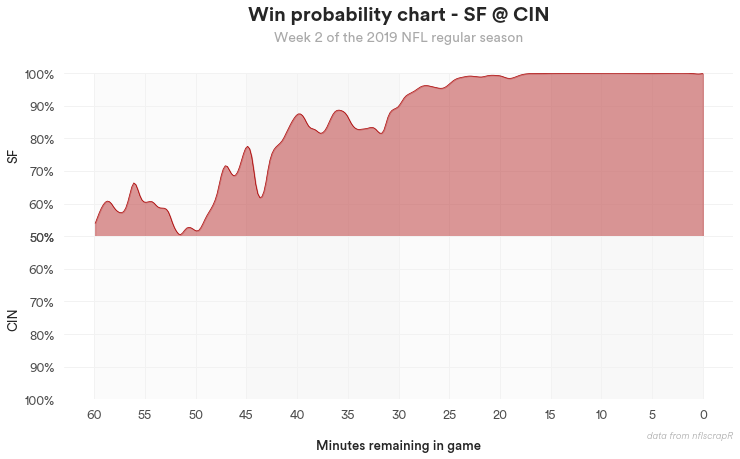

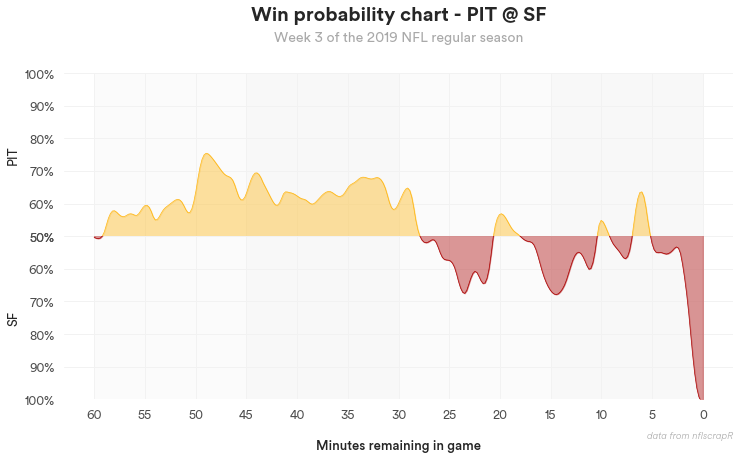

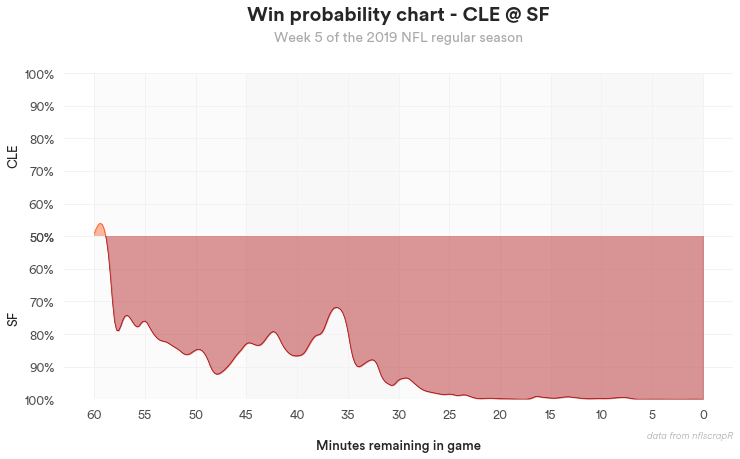

In [9]:
# Looping through SFs game IDs, pulling home team and away team to use as column names and pull correct team colors

team = 'SF'
schedule = get_schedule(team)
team_colors = colors.get_colors()

game_ids = list(schedule['game_id'])
bg_alpha_1 = 0.3
bg_alpha_2 = 0.65
smoothing = 0.98


for g, game in enumerate(game_ids):
    
    home_team, away_team, week = schedule[schedule['game_id'] == game][['home_team', 'away_team', 'week']].values[0]
    
    win_probs = (df[df['game_id'] == game][['away_wp', 'home_wp', 'game_seconds_remaining']]
                 .rename(columns={'home_wp': home_team, 'away_wp': away_team, 'game_seconds_remaining': 'game_minutes_remaining'})
                 )
    
    win_probs = win_probs.groupby('game_minutes_remaining')[home_team, away_team].mean().reset_index().dropna()
    
    win_probs['game_minutes_remaining'] = win_probs['game_minutes_remaining']/60
    
    f, ax = plt.subplots(figsize=(12, 6))
    plt.subplots_adjust(hspace = 0)
    
    #Draw home team
    
    plt.subplot(2, 1, 1)
    
    x=win_probs['game_minutes_remaining'].values
    y=win_probs[away_team].values
    
    sp = csaps.UnivariateCubicSmoothingSpline(x, y, smooth=smoothing)

    xs = np.linspace(x[0], x[-1], 300)
    ys = sp(xs)
    
    ax = sns.lineplot(x=xs, y=ys, color=team_colors[away_team], lw=0.7)
    
    ax.text(x=0.5, y=1.3, s='Win probability chart - {} @ {}'.format(away_team, home_team), fontsize=20, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
    ax.text(x=0.5, y=1.18, s='Week {} of the 2019 NFL regular season'.format(week), fontsize=14, color='darkgray', ha='center', va='bottom', transform=ax.transAxes)

    
    plt.axhline(y=50, color='grey', linestyle='--', alpha=0.3)
    
    plt.fill_between(xs, 
                     ys, 
                     color=team_colors[away_team], 
                     alpha = 0.4,
                     edgecolor=None
                    )
    
    #backgrounds to separate quarters
    plt.fill_between([60,45], y1=100, color='whitesmoke', alpha=bg_alpha_1, edgecolor=None, zorder=-2)
    plt.fill_between([45,30], y1=100, color='whitesmoke', alpha=bg_alpha_2, edgecolor=None, zorder=-2)
    plt.fill_between([30,15], y1=100, color='whitesmoke', alpha=bg_alpha_1, edgecolor=None, zorder=-2)
    plt.fill_between([15,0], y1=100, color='whitesmoke', alpha=bg_alpha_2, edgecolor=None, zorder=-2)  

    ax.set_ylim((0.5,1))
    plt.ylabel(away_team, weight='regular')
    
    ax.yaxis.set_major_formatter(FuncFormatter('{:.0%}'.format))
    ax.xaxis.set_major_locator(plt.MaxNLocator(14))
    
    ax.invert_xaxis()
    
    plt.subplot(2, 1, 2)
    
    x=win_probs['game_minutes_remaining'].values
    y=win_probs[home_team].values
    
    sp = csaps.UnivariateCubicSmoothingSpline(x, y, smooth=smoothing)

    xs = np.linspace(x[0], x[-1], 300)
    ys = sp(xs)
    
    ax = sns.lineplot(x=xs, y=ys, color=team_colors[home_team], lw=0.7)
    
    plt.fill_between(xs, 
                     ys, 
                     color=team_colors[home_team], 
                     alpha = 0.4,
                     edgecolor=None
                    )
    
    #backgrounds to separate quarters
    plt.fill_between([60,45], y1=100, color='whitesmoke', alpha=bg_alpha_1, edgecolor=None, zorder=-2)
    plt.fill_between([45,30], y1=100, color='whitesmoke', alpha=bg_alpha_2, edgecolor=None, zorder=-2)
    plt.fill_between([30,15], y1=100, color='whitesmoke', alpha=bg_alpha_1, edgecolor=None, zorder=-2)
    plt.fill_between([15,0], y1=100, color='whitesmoke', alpha=bg_alpha_2, edgecolor=None, zorder=-2)  
    
    ax.set_ylim((0.5,1))
    ax.yaxis.set_major_formatter(FuncFormatter('{:.0%}'.format))
    ax.xaxis.set_major_locator(plt.MaxNLocator(14))
    
    ax.invert_xaxis()
    ax.invert_yaxis()
    
    
    plt.ylabel(home_team, weight='regular')
    plt.xlabel("\nMinutes remaining in game", weight='medium')
    
    ax.text(x=1, 
        y=-0.25, 
        s='data from nflscrapR', 
        fontsize=10,
        weight='light',
        style='italic',
        color='darkgray', 
        ha='right', 
        va='bottom', 
        transform=ax.transAxes)
    
    
    sns.despine(left=True, right=True, bottom=True, top=True)
    
    filename = str(away_team + '_at_' + home_team)
    
    plt.savefig('output/' + filename + '_smooth.png', format='png', dpi=300, bbox_inches='tight')
    
    